In [515]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt



In [516]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [517]:
# building_id
#columns = X.columns
data_train = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [518]:
data = data_train.append(X_test, ignore_index=True, sort=False)
data = data.drop(['building_id'], axis=1)
print(data.isnull().values.any())

True


In [519]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data['total_price']
data.isnull().values.any()

False

In [520]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['total_price'] = sale_price
data.head()


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,0.7,1.000000,0.220133,0.107143,0.75,0.2,0.300577,1.0,0.005952,0.042916,...,0.034503,1.0,0.045336,1.0,0.135021,0.0,0.181915,0.0,0.031126,6.476038e+05
1,0.7,0.222222,0.269487,0.142857,0.25,0.2,0.379486,1.0,0.005952,0.042916,...,0.016657,1.0,0.033208,1.0,0.868705,0.0,0.979105,0.0,0.036191,3.321452e+06
2,0.7,0.222222,0.461026,0.107143,0.25,0.2,0.288697,1.0,0.005952,0.042916,...,0.046401,1.0,0.061219,1.0,0.862568,0.0,0.979317,0.0,0.049197,9.570885e+06
3,0.7,1.000000,0.890325,0.821429,0.00,0.2,0.889899,0.0,0.005952,0.079516,...,0.011898,1.0,0.036096,1.0,0.139679,0.0,0.220238,0.0,0.090022,1.421501e+07
4,0.0,1.000000,0.996866,0.035714,1.00,0.2,0.330351,1.0,0.005952,0.042916,...,0.010708,1.0,0.013572,1.0,0.140720,0.0,0.225440,0.0,0.112169,7.627120e+05


In [521]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['total_price'] = sale_price
data.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,0.7,1.000000,0.220133,0.107143,0.75,0.2,0.300577,1.0,0.005952,0.042916,...,0.034503,1.0,0.045336,1.0,0.135021,0.0,0.181915,0.0,0.031126,6.476038e+05
1,0.7,0.222222,0.269487,0.142857,0.25,0.2,0.379486,1.0,0.005952,0.042916,...,0.016657,1.0,0.033208,1.0,0.868705,0.0,0.979105,0.0,0.036191,3.321452e+06
2,0.7,0.222222,0.461026,0.107143,0.25,0.2,0.288697,1.0,0.005952,0.042916,...,0.046401,1.0,0.061219,1.0,0.862568,0.0,0.979317,0.0,0.049197,9.570885e+06
3,0.7,1.000000,0.890325,0.821429,0.00,0.2,0.889899,0.0,0.005952,0.079516,...,0.011898,1.0,0.036096,1.0,0.139679,0.0,0.220238,0.0,0.090022,1.421501e+07
4,0.0,1.000000,0.996866,0.035714,1.00,0.2,0.330351,1.0,0.005952,0.042916,...,0.010708,1.0,0.013572,1.0,0.140720,0.0,0.225440,0.0,0.112169,7.627120e+05


In [522]:
train = data.iloc[:60000]
test  = data.iloc[60000:]
test.drop('total_price', axis=1, inplace=True)

/home/islab/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [523]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('total_price', axis=1), train['total_price'], test_size=0.2, random_state=42)

In [524]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(233, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)

        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):

        #x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [525]:
train_batch = np.array_split(X_train, 50)
label_batch = np.array_split(y_train, 50)

In [526]:
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float().to(device)
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1).to(device)

X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().view(-1, 1).to(device)

In [527]:
model = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

output = model(train_batch[0])
print(label_batch[0])
loss = criterion(output, label_batch[0])
#loss = criterion(output, label_batch[0])
print(output)

output = model(train_batch[1])
loss = criterion(output, label_batch[i])
#loss = criterion(output, label_batch[1])
print(loss)

tensor([[1.5626e+06],
        [1.7368e+06],
        [4.0604e+06],
        [3.6722e+05],
        [9.5709e+06],
        [1.4838e+07],
        [1.3601e+07],
        [1.0117e+07],
        [8.7190e+06],
        [4.2459e+06],
        [6.5210e+06],
        [3.3215e+06],
        [9.1416e+06],
        [4.1609e+07],
        [7.0013e+06],
        [2.9901e+06],
        [1.1469e+07],
        [7.4930e+06],
        [3.1358e+06],
        [1.5693e+08],
        [3.7429e+06],
        [2.7480e+07],
        [1.2401e+07],
        [7.9961e+06],
        [9.5481e+07],
        [3.9005e+06],
        [8.3549e+06],
        [2.1056e+06],
        [3.8214e+06],
        [2.7261e+06],
        [1.4465e+08],
        [2.0135e+07],
        [1.0117e+07],
        [7.9961e+06],
        [5.5972e+06],
        [8.2211e+06],
        [4.0202e+06],
        [2.2019e+06],
        [3.6400e+07],
        [1.0673e+07],
        [2.9541e+06],
        [5.8772e+06],
        [4.4698e+06],
        [2.7434e+06],
        [2.5196e+07],
        [3

In [ ]:
model = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

epochs = 2000
train_losses, test_losses = [], []

for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        #loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        
        
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
            #test_loss = criterion(predictions, y_val)
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.4f}.. ".format(loss),
              "Test Loss: {:.4f}.. ".format(test_loss))

Epoch: 1/2000..  Training Loss: 11.8913..  Test Loss: 11.8650.. 
Epoch: 2/2000..  Training Loss: 10.0634..  Test Loss: 10.0631.. 
Epoch: 3/2000..  Training Loss: 9.0035..  Test Loss: 9.0122.. 
Epoch: 4/2000..  Training Loss: 8.2551..  Test Loss: 8.2682.. 
Epoch: 5/2000..  Training Loss: 7.6631..  Test Loss: 7.6783.. 
Epoch: 6/2000..  Training Loss: 7.1501..  Test Loss: 7.1666.. 
Epoch: 7/2000..  Training Loss: 6.6951..  Test Loss: 6.7129.. 
Epoch: 8/2000..  Training Loss: 6.3018..  Test Loss: 6.3208.. 
Epoch: 9/2000..  Training Loss: 5.9628..  Test Loss: 5.9828.. 
Epoch: 10/2000..  Training Loss: 5.6652..  Test Loss: 5.6859.. 
Epoch: 11/2000..  Training Loss: 5.3995..  Test Loss: 5.4208.. 
Epoch: 12/2000..  Training Loss: 5.1590..  Test Loss: 5.1808.. 
Epoch: 13/2000..  Training Loss: 4.9389..  Test Loss: 4.9611.. 
Epoch: 14/2000..  Training Loss: 4.7357..  Test Loss: 4.7582.. 
Epoch: 15/2000..  Training Loss: 4.5448..  Test Loss: 4.5675.. 
Epoch: 16/2000..  Training Loss: 4.3624..  Te

Epoch: 129/2000..  Training Loss: 1.0483..  Test Loss: 1.0540.. 
Epoch: 130/2000..  Training Loss: 1.0476..  Test Loss: 1.0532.. 
Epoch: 131/2000..  Training Loss: 1.0468..  Test Loss: 1.0524.. 
Epoch: 132/2000..  Training Loss: 1.0460..  Test Loss: 1.0515.. 
Epoch: 133/2000..  Training Loss: 1.0452..  Test Loss: 1.0507.. 
Epoch: 134/2000..  Training Loss: 1.0444..  Test Loss: 1.0498.. 
Epoch: 135/2000..  Training Loss: 1.0435..  Test Loss: 1.0489.. 
Epoch: 136/2000..  Training Loss: 1.0427..  Test Loss: 1.0480.. 
Epoch: 137/2000..  Training Loss: 1.0418..  Test Loss: 1.0470.. 
Epoch: 138/2000..  Training Loss: 1.0409..  Test Loss: 1.0461.. 
Epoch: 139/2000..  Training Loss: 1.0400..  Test Loss: 1.0451.. 
Epoch: 140/2000..  Training Loss: 1.0391..  Test Loss: 1.0441.. 
Epoch: 141/2000..  Training Loss: 1.0381..  Test Loss: 1.0431.. 
Epoch: 142/2000..  Training Loss: 1.0372..  Test Loss: 1.0420.. 
Epoch: 143/2000..  Training Loss: 1.0362..  Test Loss: 1.0410.. 
Epoch: 144/2000..  Traini

Epoch: 257/2000..  Training Loss: 0.7856..  Test Loss: 0.7721.. 
Epoch: 258/2000..  Training Loss: 0.7843..  Test Loss: 0.7708.. 
Epoch: 259/2000..  Training Loss: 0.7829..  Test Loss: 0.7694.. 
Epoch: 260/2000..  Training Loss: 0.7815..  Test Loss: 0.7681.. 
Epoch: 261/2000..  Training Loss: 0.7802..  Test Loss: 0.7668.. 
Epoch: 262/2000..  Training Loss: 0.7789..  Test Loss: 0.7656.. 
Epoch: 263/2000..  Training Loss: 0.7776..  Test Loss: 0.7643.. 
Epoch: 264/2000..  Training Loss: 0.7763..  Test Loss: 0.7631.. 
Epoch: 265/2000..  Training Loss: 0.7750..  Test Loss: 0.7619.. 
Epoch: 266/2000..  Training Loss: 0.7738..  Test Loss: 0.7607.. 
Epoch: 267/2000..  Training Loss: 0.7725..  Test Loss: 0.7595.. 
Epoch: 268/2000..  Training Loss: 0.7713..  Test Loss: 0.7584.. 
Epoch: 269/2000..  Training Loss: 0.7701..  Test Loss: 0.7572.. 
Epoch: 270/2000..  Training Loss: 0.7689..  Test Loss: 0.7561.. 
Epoch: 271/2000..  Training Loss: 0.7677..  Test Loss: 0.7549.. 
Epoch: 272/2000..  Traini

Epoch: 385/2000..  Training Loss: 0.6281..  Test Loss: 0.6170.. 
Epoch: 386/2000..  Training Loss: 0.6274..  Test Loss: 0.6162.. 
Epoch: 387/2000..  Training Loss: 0.6266..  Test Loss: 0.6154.. 
Epoch: 388/2000..  Training Loss: 0.6259..  Test Loss: 0.6146.. 
Epoch: 389/2000..  Training Loss: 0.6251..  Test Loss: 0.6138.. 
Epoch: 390/2000..  Training Loss: 0.6244..  Test Loss: 0.6131.. 
Epoch: 391/2000..  Training Loss: 0.6237..  Test Loss: 0.6123.. 
Epoch: 392/2000..  Training Loss: 0.6230..  Test Loss: 0.6116.. 
Epoch: 393/2000..  Training Loss: 0.6222..  Test Loss: 0.6108.. 
Epoch: 394/2000..  Training Loss: 0.6215..  Test Loss: 0.6101.. 
Epoch: 395/2000..  Training Loss: 0.6208..  Test Loss: 0.6093.. 
Epoch: 396/2000..  Training Loss: 0.6201..  Test Loss: 0.6086.. 
Epoch: 397/2000..  Training Loss: 0.6193..  Test Loss: 0.6079.. 
Epoch: 398/2000..  Training Loss: 0.6186..  Test Loss: 0.6071.. 
Epoch: 399/2000..  Training Loss: 0.6180..  Test Loss: 0.6064.. 
Epoch: 400/2000..  Traini

Epoch: 517/2000..  Training Loss: 0.5326..  Test Loss: nan.. 
Epoch: 518/2000..  Training Loss: 0.5320..  Test Loss: nan.. 
Epoch: 519/2000..  Training Loss: 0.5313..  Test Loss: nan.. 
Epoch: 520/2000..  Training Loss: 0.5306..  Test Loss: nan.. 
Epoch: 521/2000..  Training Loss: 0.5299..  Test Loss: nan.. 
Epoch: 522/2000..  Training Loss: 0.5291..  Test Loss: nan.. 
Epoch: 523/2000..  Training Loss: 0.5284..  Test Loss: nan.. 
Epoch: 524/2000..  Training Loss: 0.5277..  Test Loss: nan.. 
Epoch: 525/2000..  Training Loss: 0.5270..  Test Loss: nan.. 
Epoch: 526/2000..  Training Loss: 0.5262..  Test Loss: nan.. 
Epoch: 527/2000..  Training Loss: 0.5256..  Test Loss: nan.. 
Epoch: 528/2000..  Training Loss: 0.5249..  Test Loss: nan.. 
Epoch: 529/2000..  Training Loss: 0.5242..  Test Loss: nan.. 
Epoch: 530/2000..  Training Loss: 0.5236..  Test Loss: nan.. 
Epoch: 531/2000..  Training Loss: 0.5230..  Test Loss: nan.. 
Epoch: 532/2000..  Training Loss: 0.5224..  Test Loss: nan.. 
Epoch: 5

Epoch: 653/2000..  Training Loss: 0.4563..  Test Loss: nan.. 
Epoch: 654/2000..  Training Loss: 0.4558..  Test Loss: nan.. 
Epoch: 655/2000..  Training Loss: 0.4554..  Test Loss: nan.. 
Epoch: 656/2000..  Training Loss: 0.4550..  Test Loss: nan.. 
Epoch: 657/2000..  Training Loss: 0.4544..  Test Loss: nan.. 
Epoch: 658/2000..  Training Loss: 0.4540..  Test Loss: nan.. 
Epoch: 659/2000..  Training Loss: 0.4535..  Test Loss: nan.. 
Epoch: 660/2000..  Training Loss: 0.4531..  Test Loss: nan.. 
Epoch: 661/2000..  Training Loss: 0.4527..  Test Loss: nan.. 
Epoch: 662/2000..  Training Loss: 0.4523..  Test Loss: nan.. 
Epoch: 663/2000..  Training Loss: 0.4518..  Test Loss: nan.. 
Epoch: 664/2000..  Training Loss: 0.4513..  Test Loss: nan.. 
Epoch: 665/2000..  Training Loss: 0.4509..  Test Loss: nan.. 
Epoch: 666/2000..  Training Loss: 0.4504..  Test Loss: nan.. 
Epoch: 667/2000..  Training Loss: 0.4500..  Test Loss: nan.. 
Epoch: 668/2000..  Training Loss: 0.4496..  Test Loss: nan.. 
Epoch: 6

Epoch: 789/2000..  Training Loss: 0.4065..  Test Loss: nan.. 
Epoch: 790/2000..  Training Loss: 0.4062..  Test Loss: nan.. 
Epoch: 791/2000..  Training Loss: 0.4059..  Test Loss: nan.. 
Epoch: 792/2000..  Training Loss: 0.4057..  Test Loss: nan.. 
Epoch: 793/2000..  Training Loss: 0.4053..  Test Loss: nan.. 
Epoch: 794/2000..  Training Loss: 0.4051..  Test Loss: nan.. 
Epoch: 795/2000..  Training Loss: 0.4046..  Test Loss: nan.. 
Epoch: 796/2000..  Training Loss: 0.4044..  Test Loss: nan.. 
Epoch: 797/2000..  Training Loss: 0.4040..  Test Loss: nan.. 
Epoch: 798/2000..  Training Loss: 0.4036..  Test Loss: nan.. 
Epoch: 799/2000..  Training Loss: 0.4033..  Test Loss: nan.. 
Epoch: 800/2000..  Training Loss: 0.4029..  Test Loss: nan.. 
Epoch: 801/2000..  Training Loss: 0.4028..  Test Loss: nan.. 
Epoch: 802/2000..  Training Loss: 0.4024..  Test Loss: nan.. 
Epoch: 803/2000..  Training Loss: 0.4020..  Test Loss: nan.. 
Epoch: 804/2000..  Training Loss: 0.4015..  Test Loss: nan.. 
Epoch: 8

Epoch: 925/2000..  Training Loss: 0.3686..  Test Loss: nan.. 
Epoch: 926/2000..  Training Loss: 0.3685..  Test Loss: nan.. 
Epoch: 927/2000..  Training Loss: 0.3680..  Test Loss: nan.. 
Epoch: 928/2000..  Training Loss: 0.3679..  Test Loss: nan.. 
Epoch: 929/2000..  Training Loss: 0.3676..  Test Loss: nan.. 
Epoch: 930/2000..  Training Loss: 0.3675..  Test Loss: nan.. 
Epoch: 931/2000..  Training Loss: 0.3673..  Test Loss: nan.. 
Epoch: 932/2000..  Training Loss: 0.3671..  Test Loss: nan.. 
Epoch: 933/2000..  Training Loss: 0.3669..  Test Loss: nan.. 
Epoch: 934/2000..  Training Loss: 0.3666..  Test Loss: nan.. 
Epoch: 935/2000..  Training Loss: 0.3664..  Test Loss: nan.. 
Epoch: 936/2000..  Training Loss: 0.3663..  Test Loss: nan.. 
Epoch: 937/2000..  Training Loss: 0.3661..  Test Loss: nan.. 
Epoch: 938/2000..  Training Loss: 0.3658..  Test Loss: nan.. 
Epoch: 939/2000..  Training Loss: 0.3656..  Test Loss: nan.. 
Epoch: 940/2000..  Training Loss: 0.3654..  Test Loss: nan.. 
Epoch: 9

Epoch: 1057/2000..  Training Loss: 0.3440..  Test Loss: nan.. 
Epoch: 1058/2000..  Training Loss: 0.3439..  Test Loss: nan.. 
Epoch: 1059/2000..  Training Loss: 0.3438..  Test Loss: nan.. 
Epoch: 1060/2000..  Training Loss: 0.3435..  Test Loss: nan.. 
Epoch: 1061/2000..  Training Loss: 0.3433..  Test Loss: nan.. 
Epoch: 1062/2000..  Training Loss: 0.3433..  Test Loss: nan.. 
Epoch: 1063/2000..  Training Loss: 0.3429..  Test Loss: nan.. 
Epoch: 1064/2000..  Training Loss: 0.3430..  Test Loss: nan.. 
Epoch: 1065/2000..  Training Loss: 0.3427..  Test Loss: nan.. 
Epoch: 1066/2000..  Training Loss: 0.3425..  Test Loss: nan.. 
Epoch: 1067/2000..  Training Loss: 0.3424..  Test Loss: nan.. 
Epoch: 1068/2000..  Training Loss: 0.3423..  Test Loss: nan.. 
Epoch: 1069/2000..  Training Loss: 0.3418..  Test Loss: nan.. 
Epoch: 1070/2000..  Training Loss: 0.3419..  Test Loss: nan.. 
Epoch: 1071/2000..  Training Loss: 0.3417..  Test Loss: nan.. 
Epoch: 1072/2000..  Training Loss: 0.3414..  Test Loss:

Epoch: 1189/2000..  Training Loss: 0.3228..  Test Loss: nan.. 
Epoch: 1190/2000..  Training Loss: 0.3229..  Test Loss: nan.. 
Epoch: 1191/2000..  Training Loss: 0.3224..  Test Loss: nan.. 
Epoch: 1192/2000..  Training Loss: 0.3224..  Test Loss: nan.. 
Epoch: 1193/2000..  Training Loss: 0.3222..  Test Loss: nan.. 
Epoch: 1194/2000..  Training Loss: 0.3222..  Test Loss: nan.. 
Epoch: 1195/2000..  Training Loss: 0.3219..  Test Loss: nan.. 
Epoch: 1196/2000..  Training Loss: 0.3220..  Test Loss: nan.. 
Epoch: 1197/2000..  Training Loss: 0.3218..  Test Loss: nan.. 
Epoch: 1198/2000..  Training Loss: 0.3218..  Test Loss: nan.. 
Epoch: 1199/2000..  Training Loss: 0.3214..  Test Loss: nan.. 
Epoch: 1200/2000..  Training Loss: 0.3214..  Test Loss: nan.. 
Epoch: 1201/2000..  Training Loss: 0.3211..  Test Loss: nan.. 
Epoch: 1202/2000..  Training Loss: 0.3211..  Test Loss: nan.. 
Epoch: 1203/2000..  Training Loss: 0.3209..  Test Loss: nan.. 
Epoch: 1204/2000..  Training Loss: 0.3209..  Test Loss:

Epoch: 1321/2000..  Training Loss: 0.3054..  Test Loss: nan.. 
Epoch: 1322/2000..  Training Loss: 0.3047..  Test Loss: nan.. 
Epoch: 1323/2000..  Training Loss: 0.3048..  Test Loss: nan.. 
Epoch: 1324/2000..  Training Loss: 0.3041..  Test Loss: nan.. 
Epoch: 1325/2000..  Training Loss: 0.3044..  Test Loss: nan.. 
Epoch: 1326/2000..  Training Loss: 0.3037..  Test Loss: nan.. 
Epoch: 1327/2000..  Training Loss: 0.3038..  Test Loss: nan.. 
Epoch: 1328/2000..  Training Loss: 0.3030..  Test Loss: nan.. 
Epoch: 1329/2000..  Training Loss: 0.3033..  Test Loss: nan.. 
Epoch: 1330/2000..  Training Loss: 0.3029..  Test Loss: nan.. 
Epoch: 1331/2000..  Training Loss: 0.3029..  Test Loss: nan.. 
Epoch: 1332/2000..  Training Loss: 0.3024..  Test Loss: nan.. 
Epoch: 1333/2000..  Training Loss: 0.3021..  Test Loss: nan.. 
Epoch: 1334/2000..  Training Loss: 0.3020..  Test Loss: nan.. 
Epoch: 1335/2000..  Training Loss: 0.3016..  Test Loss: nan.. 
Epoch: 1336/2000..  Training Loss: 0.3017..  Test Loss:

Epoch: 1453/2000..  Training Loss: 0.2882..  Test Loss: nan.. 
Epoch: 1454/2000..  Training Loss: 0.2878..  Test Loss: nan.. 
Epoch: 1455/2000..  Training Loss: 0.2877..  Test Loss: nan.. 
Epoch: 1456/2000..  Training Loss: 0.2875..  Test Loss: nan.. 
Epoch: 1457/2000..  Training Loss: 0.2875..  Test Loss: nan.. 
Epoch: 1458/2000..  Training Loss: 0.2873..  Test Loss: nan.. 
Epoch: 1459/2000..  Training Loss: 0.2870..  Test Loss: nan.. 
Epoch: 1460/2000..  Training Loss: 0.2868..  Test Loss: nan.. 
Epoch: 1461/2000..  Training Loss: 0.2867..  Test Loss: nan.. 
Epoch: 1462/2000..  Training Loss: 0.2866..  Test Loss: nan.. 
Epoch: 1463/2000..  Training Loss: 0.2864..  Test Loss: nan.. 
Epoch: 1464/2000..  Training Loss: 0.2864..  Test Loss: nan.. 
Epoch: 1465/2000..  Training Loss: 0.2863..  Test Loss: nan.. 
Epoch: 1466/2000..  Training Loss: 0.2860..  Test Loss: nan.. 
Epoch: 1467/2000..  Training Loss: 0.2859..  Test Loss: nan.. 
Epoch: 1468/2000..  Training Loss: 0.2857..  Test Loss:

Epoch: 1585/2000..  Training Loss: 0.2735..  Test Loss: nan.. 
Epoch: 1586/2000..  Training Loss: 0.2735..  Test Loss: nan.. 
Epoch: 1587/2000..  Training Loss: 0.2733..  Test Loss: nan.. 
Epoch: 1588/2000..  Training Loss: 0.2734..  Test Loss: nan.. 
Epoch: 1589/2000..  Training Loss: 0.2733..  Test Loss: nan.. 
Epoch: 1590/2000..  Training Loss: 0.2733..  Test Loss: nan.. 
Epoch: 1591/2000..  Training Loss: 0.2732..  Test Loss: nan.. 
Epoch: 1592/2000..  Training Loss: 0.2732..  Test Loss: nan.. 
Epoch: 1593/2000..  Training Loss: 0.2729..  Test Loss: nan.. 
Epoch: 1594/2000..  Training Loss: 0.2728..  Test Loss: nan.. 
Epoch: 1595/2000..  Training Loss: 0.2727..  Test Loss: nan.. 
Epoch: 1596/2000..  Training Loss: 0.2725..  Test Loss: nan.. 
Epoch: 1597/2000..  Training Loss: 0.2724..  Test Loss: nan.. 
Epoch: 1598/2000..  Training Loss: 0.2725..  Test Loss: nan.. 
Epoch: 1599/2000..  Training Loss: 0.2723..  Test Loss: nan.. 
Epoch: 1600/2000..  Training Loss: 0.2721..  Test Loss:

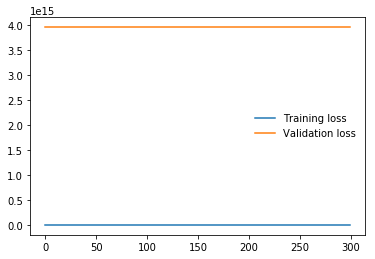

In [457]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
test = torch.from_numpy(test.values).float().to(device)

In [463]:

with torch.no_grad():
    model.eval()
    output = model.forward(test)

output.shape
output.cpu().numpy()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [460]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = output.cpu().numpy()
submission.to_csv('submission/DNN_result.csv', index=False)